In [1]:
import sys
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools

In [2]:
train_data_path = '../data/tox24_challenge_train.csv'
test_data_path = '../data/tox24_challenge_test.csv'
all_data_path = '../data/tox24_all.csv'
all_data_with_pc_data_path = '../data/tox24_alogps_oestate.csv'

df = pd.read_csv(all_data_with_pc_data_path)
df_train = pd.read_csv(train_data_path)
df_test = pd.read_csv(test_data_path)

In [3]:
# there is one duplicate in 
df[df['SMILES'].duplicated()]

,SMILES,N,ALogPS_logP,ALogPS_logS,HALOG,MW,N.1,NA,NH,O,...,Se1C2N2dd,Se1C2N==sd,SdddN,SdddN(nitro),Se2N3O1d,SddSi,Se2O1Si2d,Se1B3C3sa,Se1N3pO1a,SeaC2N3paa
813,COCCOCCO,814,-0.67,0.52,0,120.2,0,8,12,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df.query(f'SMILES == "COCCOCCO"')

,SMILES,N,ALogPS_logP,ALogPS_logS,HALOG,MW,N.1,NA,NH,O,...,Se1C2N2dd,Se1C2N==sd,SdddN,SdddN(nitro),Se2N3O1d,SddSi,Se2O1Si2d,Se1B3C3sa,Se1N3pO1a,SeaC2N3paa
752,COCCOCCO,753,-0.67,0.52,0,120.2,0,8,12,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
813,COCCOCCO,814,-0.67,0.52,0,120.2,0,8,12,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df.drop_duplicates(subset=['SMILES'], inplace=True)

In [6]:
df_11 = pd.merge(df, df_train, on='SMILES')
df_11['split'] = 'train'
df_12 = df[~df.index.isin(df_11.index)]
df_12['split'] = 'test'
df_1 = pd.concat([df_11, df_12], axis=0)
PandasTools.AddMoleculeColumnToFrame(df_1, smilesCol='SMILES')

/tmp/ipykernel_8526/1483346199.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_12['split'] = 'test'


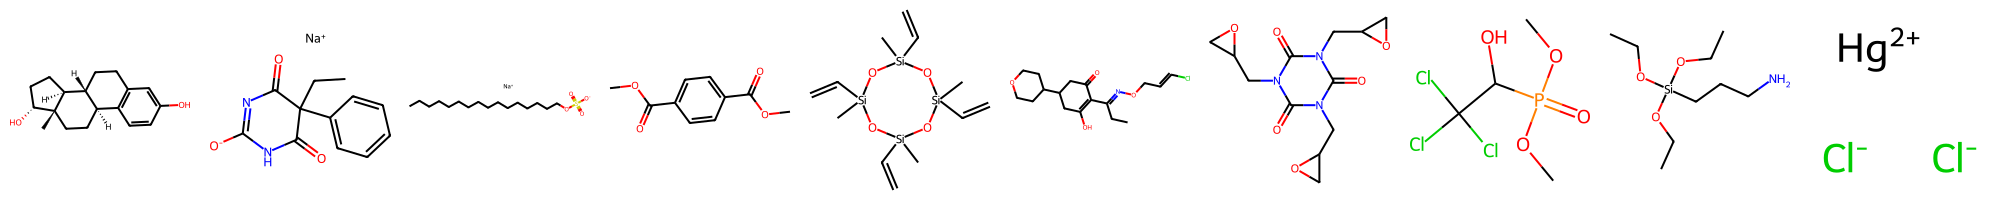

In [7]:
# visualize compounds
# tools: TMAP, UMAP,
n_sample = 10
Chem.Draw.MolsToImage(df_1.sample(n_sample)['ROMol'].to_list())

In [8]:
df_1['activity'].describe()

count    1012.000000
mean       40.813043
std        36.512641
min       -45.000000
25%        11.050000
50%        30.000000
75%        73.300000
max       111.100000
Name: activity, dtype: float64

In [9]:
from rdkit.Chem import AllChem
fpgen = AllChem.GetMorganGenerator(radius=2)
df_1['morgan_fp'] = df_1['ROMol'].apply(fpgen.GetFingerprint)

In [10]:
# to make it data
#df_1['morgan_fp'].apply(np.array).to_list()

In [11]:
import torch
from torch.utils.data import DataLoader, TensorDataset

/home/ulamaca/projects/8_minal_pyhton_env/0_minimal_python3_env/minimal_ds/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
df_1_train = df_1[df_1['split']=='train']
X0_train = df_1_train.iloc[:,2:-4].values
X1_train = np.array(df_1_train['morgan_fp'].apply(np.array).to_list())
X_train = np.concatenate((X0_train, X1_train), axis=1)
y_train = df_1_train['activity'].values

In [13]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
#X_test = torch.tensor(X_test, dtype=torch.float32)
#y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


In [14]:
import torch.nn as nn

class MLPRegressor(nn.Module):
    def __init__(self, input_dim, size_1=2048, size_2=1024, p_dropout=0.5):
        super(MLPRegressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, size_1),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(size_1, size_2),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(size_2, 1)
        )
    
    def forward(self, x):
        return self.model(x)

input_dim = X_train.shape[1]
model = MLPRegressor(input_dim)

In [18]:
# put things to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device=', device)
model.to(device)
# Move data to GPU if available
X_train = X_train.to(device)
y_train = y_train.to(device)
# X_test = X_test.to(device)
# y_test = y_test.to(device)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
#test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device= cuda


In [20]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1000

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')


Epoch [1/1000], Loss: 110.4509
Epoch [2/1000], Loss: 110.9849
Epoch [3/1000], Loss: 130.0380
Epoch [4/1000], Loss: 110.2508
Epoch [5/1000], Loss: 143.9752
Epoch [6/1000], Loss: 142.0420
Epoch [7/1000], Loss: 129.1075
Epoch [8/1000], Loss: 127.6425
Epoch [9/1000], Loss: 114.0946
Epoch [10/1000], Loss: 103.9489
Epoch [11/1000], Loss: 105.2264
Epoch [12/1000], Loss: 103.8652
Epoch [13/1000], Loss: 121.2151
Epoch [14/1000], Loss: 118.8680
Epoch [15/1000], Loss: 110.6299
Epoch [16/1000], Loss: 151.2154
Epoch [17/1000], Loss: 108.1625
Epoch [18/1000], Loss: 129.7894
Epoch [19/1000], Loss: 124.1538
Epoch [20/1000], Loss: 124.7052
Epoch [21/1000], Loss: 114.8575
Epoch [22/1000], Loss: 95.5583
Epoch [23/1000], Loss: 114.6313
Epoch [24/1000], Loss: 109.6536
Epoch [25/1000], Loss: 125.5674
Epoch [26/1000], Loss: 120.9989
Epoch [27/1000], Loss: 114.5643
Epoch [28/1000], Loss: 106.0480
Epoch [29/1000], Loss: 116.1917
Epoch [30/1000], Loss: 115.3470
Epoch [31/1000], Loss: 115.2578
Epoch [32/1000], L